In [141]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/forest/forest_sound_1.mp3


**Importing required libraries**

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

**For colours and styles**

In [143]:
from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [144]:
audio_files = glob('../input/forest/*.mp3')

In [145]:
ipd.Audio(audio_files[0])

In [146]:
y, sr = librosa.load(audio_files[0])
print(f'y: {y[:10]}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')

/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


y: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
shape y: (483000,)
sr: 22050


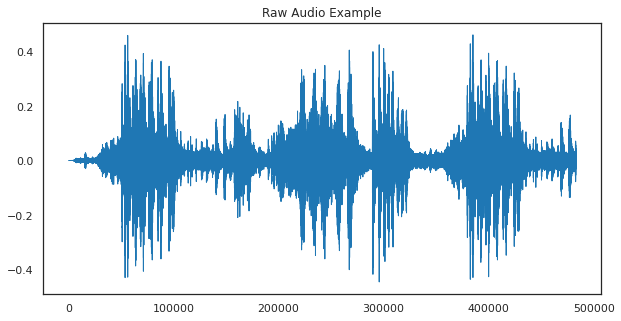

In [147]:
pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Example',
                 color=color_pal[0])
plt.show()

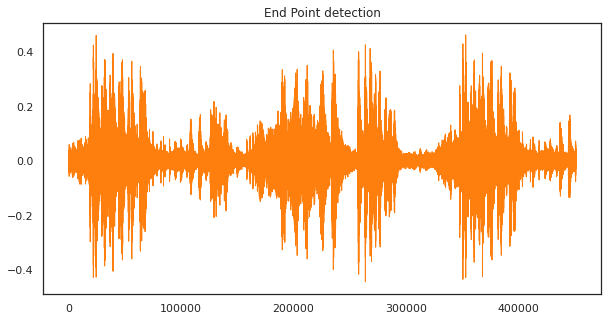

In [148]:
# Trimming leading/lagging silence
y_trimmed, _ = librosa.effects.trim(y, top_db=20)
pd.Series(y_trimmed).plot(figsize=(10, 5),
                  lw=1,
                  title='End Point detection',
                 color=color_pal[1])
plt.show()

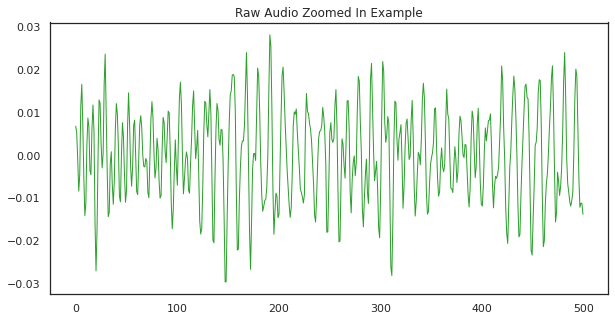

In [149]:
pd.Series(y[30000:30500]).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Zoomed In Example',
                 color=color_pal[2])
plt.show()

**NOISE REMOVAL**

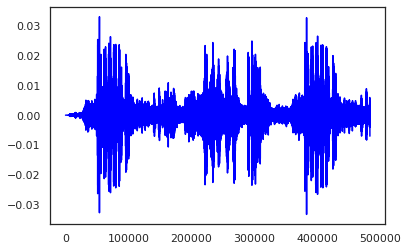

In [150]:
from scipy.signal import savgol_filter
w = savgol_filter(y, 51, 2)
x = np.arange(1, 483001, 1) 
plt.plot(x, w, 'b')  # high frequency noise removed

In [151]:
from IPython.display import Audio
wave_audio = w
Audio(wave_audio, rate=25000)

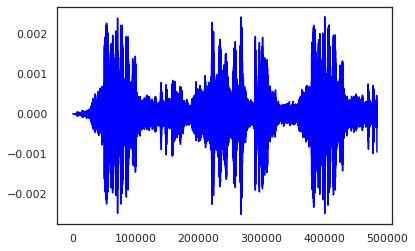

In [152]:
#Increasing window length to 501
from scipy.signal import savgol_filter
w = savgol_filter(y, 501, 2)
x = np.arange(1, 483001, 1) 
plt.plot(x, w, 'b')  # high frequency noise removed

In [153]:
wave_audio = w
Audio(wave_audio, rate=25000)

**SPECTROGRAM**

In [154]:
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_db.shape

(1025, 944)

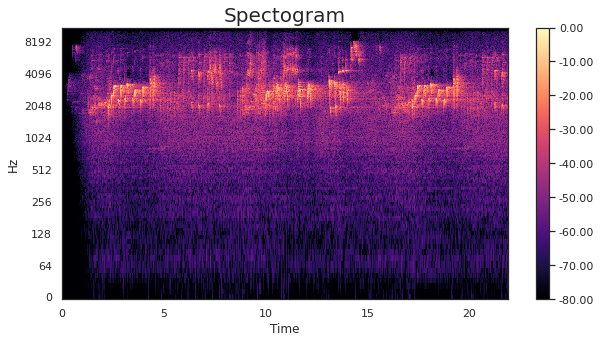

In [155]:
# Plot the transformed audio data
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(S_db,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Spectogram', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

**MEL SPECTROGRAM**

In [156]:
S = librosa.feature.melspectrogram(y=y,
                                   sr=sr,
                                   n_mels=128 * 2,)
S_db_mel = librosa.amplitude_to_db(S, ref=np.max)

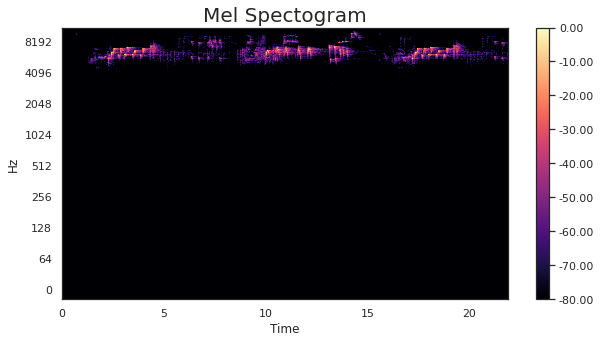

In [157]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the mel spectogram
img = librosa.display.specshow(S_db_mel,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Mel Spectogram', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

**SPECTRAL BANDWIDTH**

/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:620: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:793: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)


[Text(0.5, 1.0, 'log Power spectrogram')]

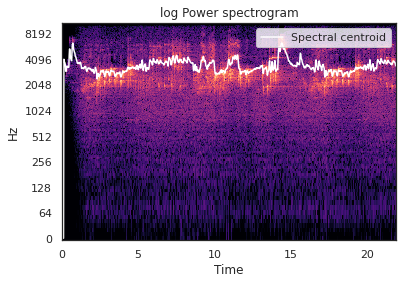

In [158]:
cent = librosa.feature.spectral_centroid(y=y, sr=sr)

S, phase = librosa.magphase(librosa.stft(y=y))
librosa.feature.spectral_centroid(S=S)

freqs, times, D = librosa.reassigned_spectrogram(y, fill_nan=True)
librosa.feature.spectral_centroid(S=np.abs(D), freq=freqs)

import matplotlib.pyplot as plt
times = librosa.times_like(cent)
fig, ax = plt.subplots()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax)
ax.plot(times, cent.T, label='Spectral centroid', color='w')
ax.legend(loc='upper right')
ax.set(title='log Power spectrogram')

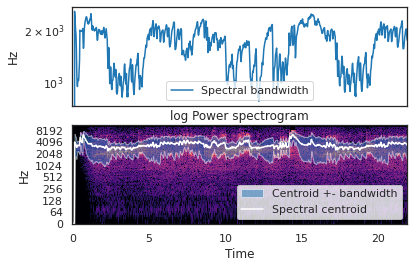

In [159]:
spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)

S, phase = librosa.magphase(librosa.stft(y=y))
librosa.feature.spectral_bandwidth(S=S)

freqs, times, D = librosa.reassigned_spectrogram(y, fill_nan=True)
librosa.feature.spectral_bandwidth(S=np.abs(D), freq=freqs)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, sharex=True)
times = librosa.times_like(spec_bw)
centroid = librosa.feature.spectral_centroid(S=S)
ax[0].semilogy(times, spec_bw[0], label='Spectral bandwidth')
ax[0].set(ylabel='Hz', xticks=[], xlim=[times.min(), times.max()])
ax[0].legend()
ax[0].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='log Power spectrogram')
ax[1].fill_between(times, np.maximum(0, centroid[0] - spec_bw[0]),
                np.minimum(centroid[0] + spec_bw[0], sr/2),
                alpha=0.5, label='Centroid +- bandwidth')
ax[1].plot(times, centroid[0], label='Spectral centroid', color='w')
ax[1].legend(loc='lower right')